<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 24/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Diffusers**

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./..')

import os

import torch
from torch import Tensor
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import ExponentialIntegrator, PredictorCorrector, EulerMaruyama, ODEProbabilityFlow
from image_gen.diffusion import VarianceExploding, VariancePreserving, SubVariancePreserving, BaseDiffusion
from image_gen.noise import LinearNoiseSchedule

from typing import Tuple

from image_gen.visualization import display_images

c:\Users\alva0\Desktop\3º ICID\2º cuatri\AAUTO3\proyecto\image-gen\examples\..\image_gen\samplers\euler_maruyama.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
epochs = 15
digit = 3

seed = 42

In [3]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Select a subset to speed up the training process
indices_digit = torch.where(data.targets == digit)[0]
data = Subset(data, indices_digit)

Diffusers define the core mechanics of the forward and reverse processes. Key aspects controlled by diffusers:
- Noise addition strategy
- Stochastic Differential Equation (SDE) formulation
- Variance preservation properties

Implemented variants:

| Diffusion Type | Key Characteristics                          | Best For                  |
|----------------|---------------------------------------------|--------------------------|
| [VE](#ve)      | Simple additive noise                     | Theoretical analysis     |
| [VP](#vp)      | Balanced signal/noise ratio               | General purpose          |
| [Sub-VP](#svp) | Improved stability                         | High-resolution images   |

### <span id="ve">**Variance Exploding (VE)**</span>

#### Mathematical Definition

Drift: $0$

Diffusion: $\sigma^t$

#### Parameters
| Parameter         | Type | Default | Description                          |
|--------------------|---|---------|--------------------------------------|
| $\sigma_{\max}$ (`sigma`)   | float | 25.0    | Maximum noise level  |

#### Characteristics
- **Training**: Fast but unstable
- **Generation**: Requires careful temperature tuning

#### Usage Example

In [4]:
model = GenerativeModel(
    diffusion=VarianceExploding,
    sampler = ODEProbabilityFlow
)

In [5]:
filename = f'saved_models/mnist_{digit}_ve_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=epochs)
    # Tip: Save the models for them to be accessible through the dashboard
    # model.save(filename)

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

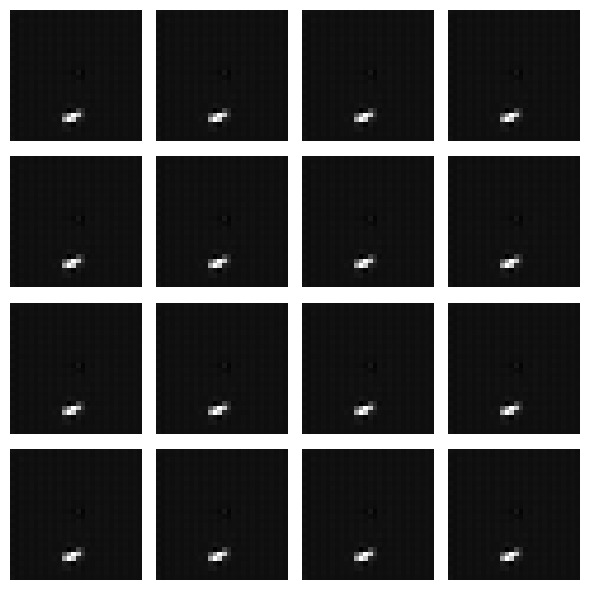

In [6]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

### <span id="vp">**Variance Preserving (VP)**</span>

#### Mathematical Definition

**Drift:** $\frac{-\beta_t \cdot x_t}{2}$

**Diffusion:** $\sqrt{\beta_t}$

#### Parameters
| Parameter         | Type | Default | Description                          |
|--------------------|---|---------|--------------------------------------|
| `schedule`    | `BaseNoiseSchedule` | `LinearNoiseSchedule` | Noise schedule for $\beta_t$ |

#### Characteristics
- **Training**: Stable convergence
- **Generation**: Natural-looking transitions

#### Usage Example

In [7]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    noise_schedule=LinearNoiseSchedule,
    sampler=ExponentialIntegrator,
)

In [ ]:
filename = f'saved_models/mnist_{digit}_vp-lin_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=20, lr=0.003)
    # Tip: Save the models for them to be accessible through the dashboard
    # model.save(filename)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

In [ ]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

### <span id="svp">**Sub-Variance Preserving (Sub-VP)**</span>

#### Mathematical Definition

**Drift:** $\frac{-\beta_t \cdot x_t}{2}$

**Diffusion:** $\sqrt{\beta_t \cdot (1 - e^{-2\sum_{s=0}^{t}\beta_{s}})}$

#### Parameters
| Parameter         | Type | Default | Description                          |
|--------------------|---|---------|--------------------------------------|
| `schedule`    | `BaseNoiseSchedule` | `LinearNoiseSchedule` | Noise schedule for $\beta_t$ (and $\beta_s$) |

#### Characteristics
- **Training**: Slower but more stable
- **Generation**: Higher fidelity outputs

#### Usage Example

In [ ]:
model = GenerativeModel(
    diffusion=SubVariancePreserving,
    noise_schedule=LinearNoiseSchedule,
    sampler=ExponentialIntegrator
)

In [ ]:
filename = f'saved_models/mnist_{digit}_svp-lin_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=20, lr=0.002)
    # Tip: Save the models for them to be accessible through the dashboard
    # model.save(filename)

In [ ]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

### **Creating Custom Diffusers**

Custom diffusers can be created by inheriting from `BaseDiffusion`. The methods that must be implemented are `forward_sde`, `forward_process` and `compute_loss` (sum of squared errors).

It is currently not supported to load models with a custom diffuser, but it is highly recommended that they implement a `config` method for future updates.

#### Implementation Example

In [ ]:
class CustomDiffuser(BaseDiffusion):
    def __init__(self, custom_param: float = 0.5):
        self.custom_param = custom_param
        
    def forward_sde(self, x: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...

    def forward_process(self, x0: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        ...

    def compute_loss(self, score: Tensor, noise: Tensor, t: Tensor) -> Tensor:
        ...
        
    def config(self) -> dict:
        return {
            "custom_param": self.custom_param
        }